# Lab 4: Hedonic Pricing
Hanna Svenson (jda6qt)

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset (update file path and adjust for your chosen dataset)
df = pd.read_csv('pierce_county_house_sales.csv')
df.head()

,sale_date,sale_price,house_square_feet,attic_finished_square_feet,basement_square_feet,attached_garage_square_feet,detached_garage_square_feet,fireplaces,hvac_description,exterior,interior,stories,roof_cover,year_built,bedrooms,bathrooms,waterfront_type,view_quality,utility_sewer
0,2020-01-02,380000,2157,0,0,528,0,0,Warm and Cool Air Zone,Frame Siding,Drywall,2,Composition Shingle,1993,3,3,NaN,NaN,SEWER/SEPTIC INSTALLED
1,2020-01-02,383000,2238,0,0,396,0,0,Forced Air,Frame Siding,Drywall,2,Composition Shingle,2017,4,3,NaN,NaN,SEWER/SEPTIC INSTALLED
2,2020-01-01,419900,1452,0,0,0,0,1,Forced Air,Frame Siding,Drywall,1,Built Up Rock,1965,3,2,NaN,NaN,SEWER/SEPTIC INSTALLED
3,2020-01-02,251660,832,0,0,0,0,0,Forced Air,Frame Vinyl,Drywall,1,Composition Shingle,1919,2,1,NaN,NaN,SEWER/SEPTIC INSTALLED
4,2020-01-02,500000,1780,0,384,484,0,1,Forced Air,Frame Siding,Drywall,1,Composition Shingle,1955,3,2,NaN,NaN,SEWER/SEPTIC INSTALLED


In [2]:
df.describe(include='object')

,sale_date,hvac_description,exterior,interior,roof_cover,waterfront_type,view_quality,utility_sewer
count,16814,16814,16813,16807,16806,553,919,16814
unique,362,10,16,2,6,4,8,5
top,2020-07-28,Forced Air,Frame Siding,Drywall,Composition Shingle,WF Lake,View Lim,SEWER/SEPTIC INSTALLED
freq,109,10382,14577,16777,15775,225,229,16765


C:\Users\jda6qt\AppData\Local\Temp\ipykernel_33732\963457060.py:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=np.log(df['sale_price']), hue=df['bathrooms']).set_title("Price")


Text(0.5, 1.0, 'Price')

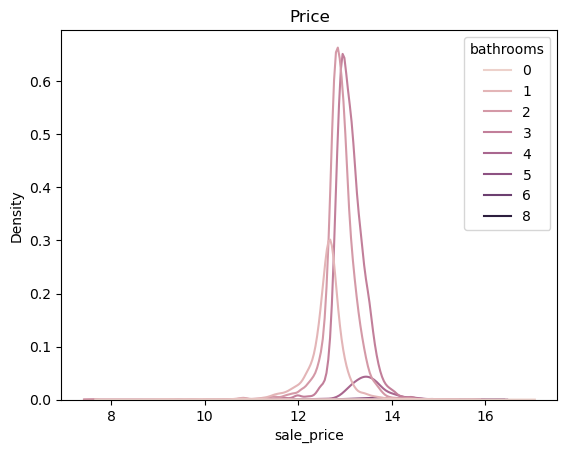

In [3]:
sns.kdeplot(x=np.log(df['sale_price']), hue=df['bathrooms']).set_title("Price")

<Axes: xlabel='house_square_feet', ylabel='sale_price'>

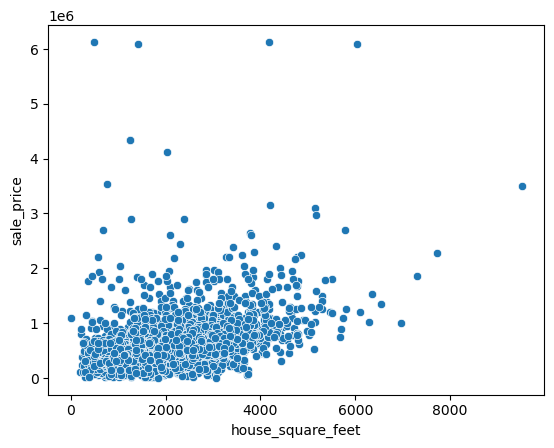

In [4]:
sns.scatterplot(x='house_square_feet', y='sale_price', data=df)

<Axes: xlabel='bedrooms', ylabel='sale_price'>

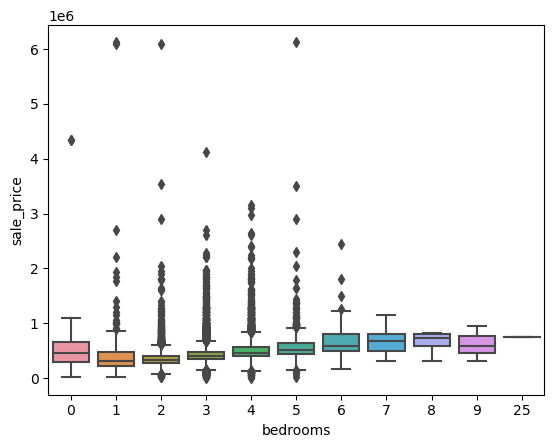

In [5]:
sns.boxplot(x='bedrooms', y='sale_price', data=df)

<Axes: xlabel='bedrooms', ylabel='bathrooms'>

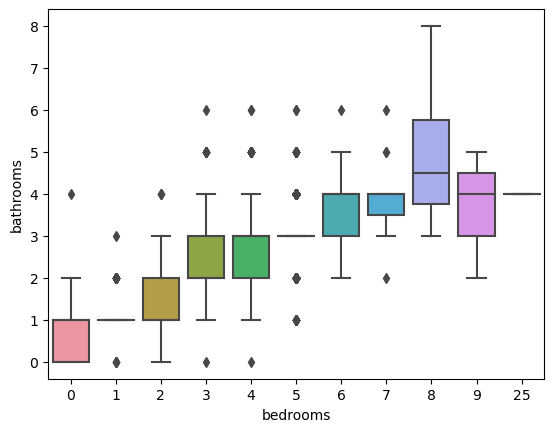

In [6]:
sns.boxplot(x='bedrooms', y='bathrooms', data=df)

2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.


In [7]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
data = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
data.head()

,sale_price,house_square_feet,attic_finished_square_feet,basement_square_feet,attached_garage_square_feet,detached_garage_square_feet,fireplaces,stories,year_built,bedrooms,...,view_quality_View Good,view_quality_View Good +,view_quality_View Lim,view_quality_View Lim +,view_quality_View Lim -,view_quality_View V-Good,utility_sewer_SEWER/SEPTIC AVAIL,utility_sewer_SEWER/SEPTIC INSTALLED,utility_sewer_SEWER/SEPTIC NO,utility_sewer_SEWER/SEPTIC NO PERC
0,380000,2157,0,0,528,0,0,2,1993,3,...,0,0,0,0,0,0,0,1,0,0
1,383000,2238,0,0,396,0,0,2,2017,4,...,0,0,0,0,0,0,0,1,0,0
2,419900,1452,0,0,0,0,1,1,1965,3,...,0,0,0,0,0,0,0,1,0,0
3,251660,832,0,0,0,0,0,1,1919,2,...,0,0,0,0,0,0,0,1,0,0
4,500000,1780,0,384,484,0,1,1,1955,3,...,0,0,0,0,0,0,0,1,0,0


3. Implement an ~80/~20 train-test split. Put the test data aside.


In [8]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

y = data['sale_price']
X = data.drop(columns=['sale_price'])
X_train, X_test, y_train, y_test = train_test_split(X,y, # Feature and target variables
                                                    test_size=.2, # Split the sample 80 train/ 20 test
                                                    random_state=100) # For replication purposes

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (13451, 415) (13451,)
Test set shape: (3363, 415) (3363,)


4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?


In [9]:
from sklearn.linear_model import LinearRegression # Import linear regression model
reg = LinearRegression().fit(X_train, y_train) # Fit the linear model
results = pd.DataFrame({'variable':reg.feature_names_in_, 'coefficient': reg.coef_}) # Regression coefficients
print('R-squared train: ', reg.score(X_train, y_train)) # R squared measure
y_train_hat = reg.predict(X_train)
rmse = np.sqrt( np.mean( (y_train - y_train_hat)**2 ))
print('RMSE train: ', rmse) # R2

print('R-squared test: ', reg.score(X_test, y_test)) # R squared measure
y_test_hat = reg.predict(X_test)
rmse = np.sqrt( np.mean( (y_test - y_test_hat)**2 ))
print('RMSE test: ', rmse) # R2

results

R-squared train:  0.5402441604146297
RMSE train:  153241.74087163262
R-squared test:  0.4792101607314486
RMSE test:  196731.0910807056


,variable,coefficient
0,house_square_feet,1.493074e+02
1,attic_finished_square_feet,1.381676e+02
2,basement_square_feet,1.085630e+02
3,attached_garage_square_feet,7.960280e+01
4,detached_garage_square_feet,8.025329e+01
...,...,...
410,view_quality_View V-Good,4.101639e+05
411,utility_sewer_SEWER/SEPTIC AVAIL,-6.071585e+05
412,utility_sewer_SEWER/SEPTIC INSTALLED,-6.081576e+05
413,utility_sewer_SEWER/SEPTIC NO,-7.205082e+05


In [10]:
# Now trying a regression with fewer input variables
model_1_features = ['house_square_feet','attic_finished_square_feet', 'basement_square_feet', 'attached_garage_square_feet', 'detached_garage_square_feet', 'fireplaces' ]
X_train_1 = X_train[model_1_features]
X_test_1 = X_test[model_1_features]
reg_model_1 = LinearRegression().fit(X_train_1, y_train)
print('Model 1 - R-squared train:', reg_model_1.score(X_train_1, y_train))
print('Model 1 - R-squared test:', reg_model_1.score(X_test_1, y_test))

y_train_hat_1 = reg_model_1.predict(X_train_1)
y_test_hat_1 = reg_model_1.predict(X_test_1)

train_rmse_1 = np.sqrt(mean_squared_error(y_train, y_train_hat_1))
test_rmse_1 = np.sqrt(mean_squared_error(y_test, y_test_hat_1))

print('Model 1 - RMSE train:', train_rmse_1)
print('Model 1 - RMSE test:', test_rmse_1)

results = pd.DataFrame({'variable':reg_model_1.feature_names_in_, 'coefficient': reg_model_1.coef_}) # Regression coefficients
results


Model 1 - R-squared train: 0.3733642419730876
Model 1 - R-squared test: 0.36170978720770697
Model 1 - RMSE train: 178904.40617719362
Model 1 - RMSE test: 217796.4727318914


,variable,coefficient
0,house_square_feet,132.497719
1,attic_finished_square_feet,156.356245
2,basement_square_feet,143.937987
3,attached_garage_square_feet,88.942602
4,detached_garage_square_feet,116.289795
5,fireplaces,28063.147802


In [11]:
# another attempt with different variables
features_model_2 = ['house_square_feet', 'year_built']
X_train_2 = X_train[features_model_2]
X_test_2 = X_test[features_model_2]

reg_model_2 = LinearRegression().fit(X_train_2, y_train)
print('Model 2 - R-squared train:', reg_model_2.score(X_train_2, y_train))
print('Model 2 - R-squared test:', reg_model_2.score(X_test_2, y_test))

y_train_hat_2 = reg_model_2.predict(X_train_2)
y_test_hat_2 = reg_model_2.predict(X_test_2)

train_rmse_2 = np.sqrt(mean_squared_error(y_train, y_train_hat_2))
test_rmse_2 = np.sqrt(mean_squared_error(y_test, y_test_hat_2))

print('Model 2 - RMSE train:', train_rmse_2)
print('Model 2 - RMSE test:', test_rmse_2)


results = pd.DataFrame({'variable':reg_model_2.feature_names_in_, 'coefficient': reg_model_2.coef_}) # Regression coefficients
results


Model 2 - R-squared train: 0.2791160968554124
Model 2 - R-squared test: 0.2836218839549053
Model 2 - RMSE train: 191887.2478657077
Model 2 - RMSE test: 230734.69574787066


,variable,coefficient
0,house_square_feet,167.509590
1,year_built,-432.589025


5. Include transformations and interactions, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?


In [12]:
data['log_sale_price'] = np.log(data['sale_price'])  # log1p handles zero values by computing log(1 + x)
data['house_age'] = 2024 - data['year_built']
data['inv_house_age'] = 1/data['house_age']
data['house_age_ihs'] = np.arcsinh(data['house_age'])
data['sale_price_ihs'] = np.arcsinh(data['sale_price'])
data['log_house_square_feet'] = np.log(data['house_square_feet'])
data['log_basement_square_feet'] = np.log(data['basement_square_feet'])
data['sqrt_attached_garage_square_feet'] = np.sqrt(data['attached_garage_square_feet'])
data['sqrt_bedrooms'] = np.sqrt(data['bedrooms'])
data['age_size_interaction'] = data['house_age'] * data['house_square_feet']
data['bed_bath_product'] = data['bedrooms'] * data['bathrooms']
data['bed_bath_ratio'] = data['bathrooms'] / data['bedrooms']
data['house_square_feet_squared'] = data['house_square_feet'] ** 2

y = data['sale_price']
X = data.drop(columns=['sale_price'])
X_train, X_test, y_train, y_test = train_test_split(X,y, # Feature and target variables
                                                    test_size=.2, # Split the sample 80 train/ 20 test
                                                    random_state=100) # For replication purposes

correlations = data.corr()['sale_price'].sort_values(ascending=False)
print(correlations.head(15))  # Top 10 most correlated features

print()
correlations = data.corr()['log_sale_price'].sort_values(ascending=False)
print(correlations.head(15))  # Top 10 most correlated features

print()
correlations = data.corr()['sale_price_ihs'].sort_values(ascending=False)
print(correlations.head(15))  # Top 10 most correlated features



C:\Users\jda6qt\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


sale_price                          1.000000
sale_price_ihs                      0.842286
log_sale_price                      0.842286
house_square_feet_squared           0.549824
house_square_feet                   0.526326
log_house_square_feet               0.459672
bathrooms                           0.409438
bed_bath_product                    0.369894
log_basement_square_feet            0.359909
fireplaces                          0.348467
attached_garage_square_feet         0.310756
waterfront_type_WF Salt             0.308183
bed_bath_ratio                      0.304048
basement_square_feet                0.269653
sqrt_attached_garage_square_feet    0.231453
Name: sale_price, dtype: float64

log_sale_price                      1.000000
sale_price_ihs                      1.000000
sale_price                          0.842286
house_square_feet                   0.578434
log_house_square_feet               0.552509
house_square_feet_squared           0.548573
bathrooms            

In [14]:
# Now trying a regression with fewer input variables
model_3_features = ['house_square_feet_squared', 'inv_house_age', 'attached_garage_square_feet', 'basement_square_feet', 'fireplaces','waterfront_type_WF Salt', 'bed_bath_product', ]
X_train_3 = X_train[model_3_features]
X_test_3 = X_test[model_3_features]
reg_model_3 = LinearRegression().fit(X_train_3, y_train)
print('Model 3 - R-squared train:', reg_model_3.score(X_train_3, y_train))
print('Model 3 - R-squared test:', reg_model_3.score(X_test_3, y_test))

y_train_hat_3 = reg_model_3.predict(X_train_3)
y_test_hat_3 = reg_model_3.predict(X_test_3)

train_rmse_3 = np.sqrt(mean_squared_error(y_train, y_train_hat_3))
test_rmse_3 = np.sqrt(mean_squared_error(y_test, y_test_hat_3))

print('Model 3 - RMSE train:', train_rmse_3)
print('Model 3 - RMSE test:', test_rmse_3)

results = pd.DataFrame({'variable':reg_model_3.feature_names_in_, 'coefficient': reg_model_3.coef_}) # Regression coefficients
results


Model 3 - R-squared train: 0.4504021845113746
Model 3 - R-squared test: 0.4911212057317651
Model 3 - RMSE train: 167546.72720523193
Model 3 - RMSE test: 194468.34854923672


,variable,coefficient
0,house_square_feet_squared,0.031218
1,inv_house_age,134057.191884
2,attached_garage_square_feet,94.162707
3,basement_square_feet,141.850260
4,fireplaces,27855.928691
5,waterfront_type_WF Salt,539878.990766
6,bed_bath_product,-3202.973902


6. Summarize your results from 1 to 5. Have you learned anything about overfitting and underfitting, or model selection?

Through EDA I examined relationships between sale price and key features. I also examined relationships between house features, for example bedrooms and bathrooms. 
Categorical variables were then encoded using one-hot encoding so they could be used in the regression models. 
Then, once the data was split, I could run regressions and compare R^2 and RMSE values on the train and test data. 
The simple linear models used data before applying transformations. I used trial and error, and common sense to come up with selections of variables that may build a good model. However, R^2 values remained relatively low. 
Implementing transformations, like logs or square roots, or calculations for house age provided more variables to explore. R^2 did improve slightly, but did not exceed a value of 0.5.

I learned that an increase of the R^2 value for training data but a decrease in test data generally means that the model is overfitting. Underfit models are generally represented by moderate R^2 values as they are not effectively capturing relationships in the model.